Screen will now be cleared in 5 Seconds
[0.         0.04908739 0.09817477 0.14726216 0.19634954 0.24543693
 0.29452431 0.3436117  0.39269908 0.44178647 0.49087385 0.53996124
 0.58904862 0.63813601 0.68722339 0.73631078 0.78539816 0.83448555
 0.88357293 0.93266032 0.9817477  1.03083509 1.07992247 1.12900986
 1.17809725 1.22718463 1.27627202 1.3253594  1.37444679 1.42353417
 1.47262156 1.52170894 1.57079633 1.61988371 1.6689711  1.71805848
 1.76714587 1.81623325 1.86532064 1.91440802 1.96349541 2.01258279
 2.06167018 2.11075756 2.15984495 2.20893233 2.25801972 2.3071071
 2.35619449 2.40528188 2.45436926 2.50345665 2.55254403 2.60163142
 2.6507188  2.69980619 2.74889357 2.79798096 2.84706834 2.89615573
 2.94524311 2.9943305  3.04341788 3.09250527 3.14159265 3.19068004
 3.23976742 3.28885481 3.33794219 3.38702958 3.43611696 3.48520435
 3.53429174 3.58337912 3.63246651 3.68155389 3.73064128 3.77972866
 3.82881605 3.87790343 3.92699082 3.9760782  4.02516559 4.07425297
 4.12334036 4.17242774 

AttributeError: 'list' object has no attribute 'ndim'

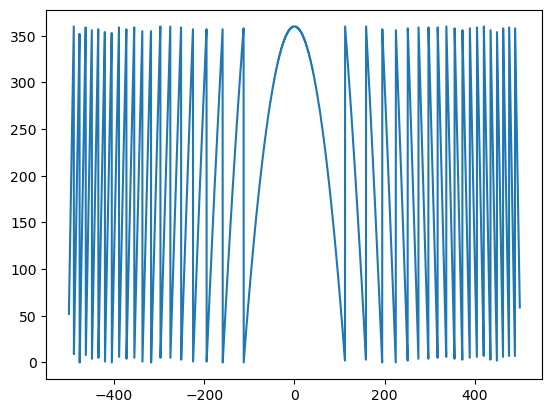

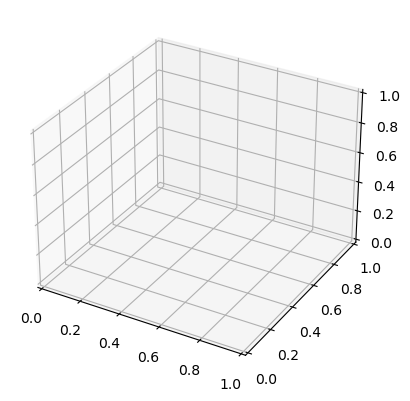

In [5]:
#script for generating a metasurface gds layout

#This script generates the flat metasurface layout to write in ebeam if the final target phase profile is a 
#conformal phase profile over a spherical lens of curvature radius 3.21mm 

#All cells should be merged for complete GDS generation. Files are split here for explanatory purposes




for z in range(1):
    d = dir()
    for obj in d:
        if not obj.startswith('__') and obj!='z':
            del globals()[obj]
            
    import os
    from time import sleep

    # some text
    print("Screen will now be cleared in 5 Seconds")
    # Waiting for 5 seconds to clear the screen
    sleep(5)
    # Clearing the Screen
#    os.system('clear')
    
    !pip install gdspy
    !pip install mlxtend

    #import necessary libraries and frameworks
    import gdspy
    import pandas as pd
    import numpy as np
    import sys
    import math

    import matplotlib.pylab as plt
    import matplotlib.pyplot

    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter
    from numpy import savetxt

    from scipy.integrate import quad

    from datetime import date
    import time

    from mlxtend.data import iris_data
    from mlxtend.plotting import scatterplotmatrix

    #input parameters
    baseUnit = 1 #layout scale(microns)
    m=baseUnit*1e6 
    nm = m*1e-9
    um = m*1e-6
    mm = m*1e-3

    bias=14.0;#converted to nm in the script
    period = 310 #period along x-axis
    periodX = 310*nm #period along x-axis
    periodY = 310*nm #period along y-axis
    #periodX = (1/DeformationX)*300*nm #period along x-axis
    #periodY = (1/DeformationY)*300*nm #period along y-axis 
    Xmax = 1*1*mm #metasurface length
    Ymax = 1*1*mm #metasurface width
    Nx = round(Xmax/periodX)-1 #number of meta-atoms along x-axis
    Ny = round(Ymax/periodY)-1 #number of meta-atoms along y-axis
    phaseStep = 2.8125*(np.pi/180);#360/128
    n_phaseLevels=128;

    today = date.today()
    date = today.strftime("%Y%m%d")
    index=z;

    n_angles=8;
    
    
    #We segment our metasurface by regions for which meta atom angular response is optimized
    #Boundaries between angles, corrected by reverse deformation, for old mold:
    #2.5deg: 132.7267091;
    #7.5deg: 397.9370274;
    #12.5deg: 664.1067295;
    #17.5deg: 931.0170776;
    #22.5deg: 1210.357483;
    #27.5deg: 1482.263277;
    #32.5deg: 1792.301508;
    #37.5deg: 2072.877536;
    #42.5deg: 2435.153535;
    #47.5deg: 2728.784759;

    #This angular data is stored in the limit_vec list below
    limit_vec=[133,398,664,934,1210,1482,1792,2072,2435,2728]

    outputFileName = 'Filename_' +str(5*index)+'deg_AngleCorr_'+ date

    #define the diameter matrix vs angle
    angular_vector=np.linspace(0,40,n_angles+1);

    phase_vec=(np.pi/180)*np.linspace(0,360,n_phaseLevels+1);
    print(phase_vec);
    #from 0 until 40deg



    #polynomial coefficients fitting the correspondance from phase to diameter period 310nm; 
    #height 1um wav 940nm meta atomindex 3.484, surronding index 1.53
    polynomials=[[1.60E-05,0.000155439,-0.003231656,0.029846808,0.121221357],
    [1.64E-05,0.000148518,-0.003196733,0.029765902,0.121241693],
    [1.74E-05,0.000130644,-0.003103352,0.029538916,0.1212999],
    [1.86E-05,0.000106923,-0.00297322,0.029199022,0.121390238],
    [1.84E-05,9.73E-05,-0.002884626,0.028853112,0.121489038],
    [1.65E-05,0.000106891,-0.002864284,0.02855391,0.12158221],
    [1.30E-05,0.000138539,-0.002936535,0.028360904,0.121647237],
    [5.74E-06,0.000219328,-0.003218521,0.028452606,0.121623903],
    [-7.23E-06,0.000373611,-0.003796595,0.028941888,0.121465347]];


    def phaseToDiam(a,x):
        ph=np.zeros((np.size(a,0),np.size(x,0)));
        for i in range(np.size(x,0)):
            for j in range(np.size(a,0)):
                ph[j][i]=a[j][4]+a[j][3]*x[i]+a[j][2]*x[i]**2+a[j][1]*x[i]**3+a[j][0]*x[i]**4;
        return ph

    diam=phaseToDiam(polynomials,phase_vec);    

    factor=um*np.ones((9,n_phaseLevels+1));
    diameter=np.multiply(factor,diam)-bias*nm
    
    #generating phase map correction for BFL+4mm
    x = np.linspace(-Xmax/2,Nx*periodX-Xmax/2,Nx)
    y = np.linspace(-Ymax/2,Ny*periodY-Ymax/2,Ny)
    x = np.float32(x);
    y = np.float32(y);

    r=np.sqrt(x**2+y**2);
    r = np.float32(r);

    X,Y = np.meshgrid(x,y)

    #Defining target phase map based on Zemax simulations of hybrid optical system
    a1=-4.973830169837029E+006;
    a2=-6.499539028024775E+008;
    a3=-2.501688494173564E+011;
    a4=-1.067364139495181E+014;
    a5=-4.836776365296349E+017;
    a6=3.317785766312701E+021;
    a7=-1.731032252580379E+025;
    a8=5.139459724125223E+028;
    a9=-7.030919285809993E+031;
    a10=-3.078069633090000E+034;
    a11=2.168674932858883E+038;
    a12=-1.923135071970658E+041;
    rmax=100*mm;


    Rmax=np.full((np.size(x),np.size(y)),rmax);
    R=np.sqrt(X**2+Y**2);

    
    phaseMap0= a1*((R/Rmax)**2) + a2*((R/Rmax)**4) + a3*((R/Rmax)**6) + a4*((R/Rmax)**8) + a5*((R/Rmax)**10) + a6*((R/Rmax)**12) + a7*((R/Rmax)**14) + a8*((R/Rmax)**16) + a9*((R/Rmax)**18) + a10*((R/Rmax)**20) + a11*((R/Rmax)**22) + a12*((R/Rmax)**24);
    phaseMap = np.round(np.remainder(phaseMap0,2*np.pi),4); #in radians
    
    

 
    #Definining the phase map profile
    xlin=np.linspace(-Xmax/2,Nx*periodX-Xmax/2,Nx)
    #plt.plot(xlin,a1*((xlin/rmax)**2) + a2*((xlin/rmax)**4) + a3*((xlin/rmax)**6) + a4*((xlin/rmax)**8) + a5*((xlin/rmax)**10) + a6*((xlin/rmax)**12) + a7*((xlin/rmax)**14) + a8*((xlin/rmax)**16) + a9*((xlin/rmax)**18) + a10*((xlin/rmax)**20) + a11*((xlin/rmax)**22) + a12*((xlin/rmax)**24))
    print('Phase Map Profile')
    plt.plot(xlin,np.rint((180/np.pi)*np.remainder(a1*((xlin/rmax)**2) + a2*((xlin/rmax)**4) + a3*((xlin/rmax)**6) + a4*((xlin/rmax)**8) + a5*((xlin/rmax)**10) + a6*((xlin/rmax)**12) + a7*((xlin/rmax)**14) + a8*((xlin/rmax)**16) + a9*((xlin/rmax)**18) + a10*((xlin/rmax)**20) + a11*((xlin/rmax)**22) + a12*((xlin/rmax)**24),2*np.pi)))

    #Deformation Correction: we proceed by reverse design to engineer deformation so that the 
    #final period after processing matches the design period

    def RadialDeformation(R):
        return 1+0.01*(((-0.000002)*(R**2))+((0.0016)*(R))+5.2951) #in absolute value

    def InverseRadialDeformation(R):
        return (1+0.01*(((-0.000002)*(R**2))+((0.0016)*(R))+5.2951))**(-1) #in absolute value

    #integration to extract the new radial positions
    def InverseRadialDisplacement(r):
        return quad(InverseRadialDeformation,0,r)[0]

    def InverseOrthoradialDisplacement(r):
        return quad(InverseOrthoradialDeformation,0,r)[0]


    #Define the new map of the new coordinates after deformation mapping
    def InverseRadialDisplacementMap(X):
        n=np.size(X,0)
        m=np.size(X,1)
        RadDisMap=np.zeros((m,n,2))
        for i in range(0,n):
            for j in range(0,m):
                RadDisMap[i][j][0]=InverseRadialDisplacement(X[i][j][0])
                RadDisMap[i][j][1]=X[i][j][1]
        return RadDisMap

    def CylindricalMap(spatialMapArg):
        n=np.size(spatialMapArg,0)
        m=np.size(spatialMapArg,1)
        CylinMap=np.zeros((m,n,2))
        for i in range(0,n):
            for j in range(0,m):
                CylinMap[i][j][0]=(((spatialMapArg[i][j][0]**2)+(spatialMapArg[i][j][1]**2))**0.5)
                CylinMap[i][j][1]=np.arctan2(spatialMapArg[i][j][1],spatialMapArg[i][j][0])
        return CylinMap

    def CartesianMap(spatialCylinMapArg):
        n=np.size(spatialCylinMapArg,0)
        m=np.size(spatialCylinMapArg,1)
        CartMap=np.zeros((m,n,2))
        for i in range(0,n):
            for j in range(0,m):
                CartMap[i][j][0]=spatialCylinMapArg[i][j][0]*np.cos(spatialCylinMapArg[i][j][1])
                CartMap[i][j][1]=spatialCylinMapArg[i][j][0]*np.sin(spatialCylinMapArg[i][j][1])
        return CartMap
    ###### generating spatial map of (x,y) cells with the total size of a phaseMap

    def spatialMapGenerator(periodX, periodY, phaseMap):
        spatialMap = [[[periodX*x-Xmax*0.5, periodY*y-Ymax*0.5] for x in range(np.size(phaseMap,1))] for y in range(np.size(phaseMap,0))]
        return spatialMap
    
    spatialMap0=spatialMapGenerator(periodX, periodY, phaseMap);
    Cylind=CylindricalMap(spatialMap0);
    RadDis=InverseRadialDisplacementMap(Cylind);
    Cart2=CartesianMap(Cylind);
    spatialMap=CartesianMap(RadDis);

    #potential to save inverse layout to avoid recomputation at every iteration
    #np.save('Cylind_1',Cylind);
    #np.save('RadDis_1',RadDis);
    #np.save('Cart2_1',Cart2);
    #np.save('spatialMap_1',spatialMap);
    #np.save('spatialMap0_1',spatialMap0);
    #Cylind=np.load('Cylind_1.npy');
    #RadDis=np.load('RadDis_1.npy');
    #Cart2=np.load('Cart2_1.npy');
    #spatialMap=np.load('spatialMap_1.npy');
    #spatialMap0=np.load('spatialMap0_1.npy');

    #Let us now compare the original spatial map and the one with reverse engineered deformation
    
    # Create a figure and 3D axes
    print('Non Deformed surface')
    fig = plt.figure();
    ax = fig.add_subplot(111, projection='3d');

    # Plot the surface
    surf = ax.plot_surface(X, Y, spatialMap0, cmap='viridis');
    
    print('Reverse Deformed surface')
    # Create a figure and 3D axes
    fig2 = plt.figure();
    ax2 = fig.add_subplot(111, projection='3d');

    # Plot the surface
    surf2 = ax2.plot_surface(X, Y, spatialMap, cmap='viridis');
    

In [ ]:
 
    
    #function to clean up cells
    def clearCell(cell):
        cell.remove_polygons(lambda pts,layer,datatype:True)

    #layer and datatype tags
    ld_Si = {"layer":1, "datatype":1}

    #creating a gdspy library
    gdspy.current_library = gdspy.GdsLibrary()
    
    lib = gdspy.GdsLibrary()
    

    #MAPPING PHASE TO META-ATOM RADIUS
    metaatomRadius = 0.5*diameter[index]
    print(metaatomRadius);
    phaseToRadius = [[phase_vec[i],round(metaatomRadius[i],4)] for i in range(n_phaseLevels)];
    phaseValue = [phaseToRadius[i][0] for i in range(n_phaseLevels)];


    #GENERATING META-ATOM lIBRARY 
    disks = [];
    for i in range(len(metaatomRadius)):
        disks.append(gdspy.Round((0, 0), metaatomRadius[i], tolerance=0.001)) 

    MAcell = []
    for i in range(len(metaatomRadius)):
        MAcell.append(lib.new_cell('metaatom-'+str(i+1)).add(disks[i]))

    def phaseToCellMap(center, phase, phaseValue, MAcell):
        for i in range(len(phaseValue)):
            if phase<phaseValue[i]+phaseStep/2 and phase>=phaseValue[i]-phaseStep/2:
                return gdspy.CellReference(MAcell[i], center)
            elif phase>max(phaseValue)+phaseStep/2:
                return gdspy.CellReference(MAcell[0], center)

    #function to generate 2D map of rectangles (metasurface)
    def metalensGenerator(phaseMap, phaseToCellMap, spatialMap):
        metasurface = []
        for x in range(len(spatialMap)):
            for y in range(len(spatialMap)):
                if (spatialMap[x][y] != 'x') and index>0 and index<len(limit_vec)-1:
                    if (np.sqrt(spatialMap[x][y][0]**2+spatialMap[x][y][1]**2)>limit_vec[index-1]) and (np.sqrt(spatialMap[x][y][0]**2+spatialMap[x][y][1]**2)<limit_vec[index]):
                        metasurface.append(phaseToCellMap(spatialMap[x][y], phaseMap[x][y], phaseValue, MAcell))
                elif (spatialMap[x][y] != 'x') and index==0:
                    if (np.sqrt(spatialMap[x][y][0]**2+spatialMap[x][y][1]**2)<limit_vec[index]) :
                        metasurface.append(phaseToCellMap(spatialMap[x][y], phaseMap[x][y], phaseValue, MAcell))
                elif (spatialMap[x][y] != 'x') and index==len(limit_vec)-1:
                    if (np.sqrt(spatialMap[x][y][0]**2+spatialMap[x][y][1]**2)>limit_vec[index]) :
                        metasurface.append(phaseToCellMap(spatialMap[x][y], phaseMap[x][y], phaseValue, MAcell))
        return metasurface

    metalens = metalensGenerator(phaseMap, phaseToCellMap, spatialMap)

    Lens=gdspy.Cell("Lens-1")
    Lens.add(metalens)

    #adding alignment marks
    am_pos = [(2.5*mm,2.5*mm), (-2.5*mm,2.5*mm), (2.5*mm,-2.5*mm), (-2.5*mm,-2.5*mm)]
    cross_length = 200*um
    cross_width = 20*um

    crosses = []
    for i in range(len(am_pos)):
        rect1 = gdspy.Rectangle((am_pos[i][0]+cross_length/2, am_pos[i][1]+cross_width/2), (am_pos[i][0]-cross_length/2, am_pos[i][1]-cross_width/2))
        rect2 = gdspy.Rectangle((am_pos[i][0]+cross_width/2, am_pos[i][1]+cross_length/2), (am_pos[i][0]-cross_width/2, am_pos[i][1]-cross_length/2))
        cross = gdspy.boolean(rect1, rect2, "or")
        crosses.append(cross)

    align_marks = gdspy.Cell('alignment-marks')
    align_marks.add(crosses)

    #writing gds file
    start_time = time.time()
    gdspy.current_library = gdspy.GdsLibrary()
    gdspy.current_library.add(Lens)
    Lens.add(align_marks)
    gdspy.write_gds(outputFileName + '.gds')
    print("--- %s seconds ---" % (time.time() - start_time))